## 1.  Yifan's method
Find similar words through modeling training on Word2Vec

In [1]:
from Data_Processor import *
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from collections import Counter
from gensim.test.utils import common_texts, get_tmpfile
from gensim.models import Word2Vec
from gensim.test.utils import datapath
from gensim import utils

import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from gensim.models import Word2Vec, CoherenceModel

import pprint

from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
model = gensim.models.Word2Vec.load('D')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Erzi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Erzi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Erzi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
model = gensim.models.Word2Vec.load('MSmodel')
items=model.wv.most_similar(['digital','platform','service','app'], topn=20)
words=[_[0] for _ in items]
for item, prob in items:
    print(item, prob)

online 0.8268601894378662
provider 0.8043113946914673
user 0.7804721593856812
robo 0.7770801782608032
capability 0.7738627195358276
tool 0.7676327228546143
ai 0.7570551633834839
active 0.75101637840271
transformation 0.7459264993667603
mobile 0.7420908808708191
content 0.7381772398948669
netting 0.7364845871925354
aim 0.735865592956543
streaming 0.7337541580200195
encrypted 0.7313905954360962
provides 0.7288263440132141
software 0.7285503149032593
creating 0.7222330570220947
wealthmanagement 0.7215610146522522
strategic 0.7180969715118408


## 2.  Ruofan's method
Find similar words through visualization and manually check

In [18]:
dirlist=[r"D:/final/Morgan_Stanley"]
DP=Data_Processor(start_month='2017-06',end_month='2020-05',
                  template=dirlist)
DP.readdata()
print(DP.datanums())
DP.specifylang()
noise=DP.removenoise() 
DP.clean()
print(DP.datanums())


([4577, 4968, 4675, 4893, 4178, 5011, 5379, 5127, 3961, 3999, 3606, 5131, 4841, 4097, 3976, 5675, 4350, 3863, 3630, 3471, 3542, 4300, 3988, 5320, 3799, 3265, 3160, 3566, 3455, 3431, 3081, 3417, 3829, 4732, 4458, 4505], 151256)
([4574, 4968, 4675, 4892, 4178, 5011, 5379, 5127, 3961, 3997, 3605, 5131, 4841, 4097, 3976, 5675, 4350, 3863, 3630, 3470, 3542, 4300, 3988, 5319, 3798, 3265, 3160, 3565, 3455, 3431, 3081, 3417, 3829, 4732, 4458, 4505], 151245)


Copy another DPt as tokenized data -> good for later network analysis (remove stop words)

In [4]:
#DP is not tokenized, choose another DPt as tokenized data for later network analysis
DPt = Data_Processor(start_month='2017-06',end_month='2020-05',
                     template=dirlist)
DPt.data=DP.data
DPt.tokenizetext()

### 2.1 Analyze the sentiment / frequency trend

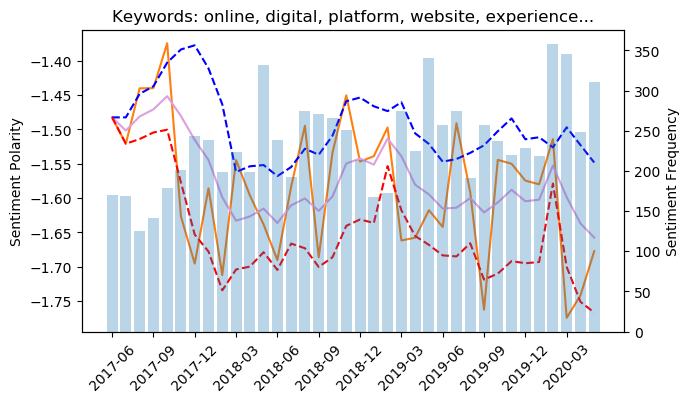

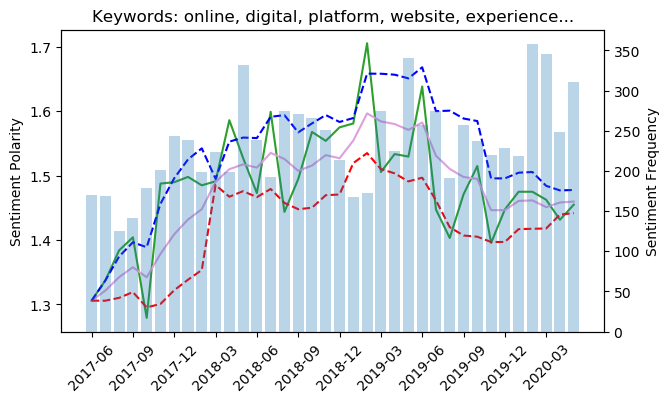

In [19]:
#choose polarity=0 for pos, 1 for neg, count means tweets containing the words with at least #count times
topic_words = ['online','digital','platform','website', 'experience',' app ','site',' ui ',
               'online account','digital platform','self service','mobile app','online experience',
              'digital service','encrypted','software','call']
DP.trend_analysis(polarity = [0,1], keyword_list = topic_words,count=1,ma=5)

**Check for the spikes / slumps in the trend charts above (see reason why)**

In [6]:
month = ['2017-09']  #choose the month here (must be a list)
#topic_words = [' app ',' apps'] #choose the topic here
tweet_result = DP.show_tweets(month_list = month, 
                            keywords = topic_words, 
                            count = 2,
                            threshold = 1, #choose only pos>2 & neg<-2 tweets
                            unique = True)  #choose only the unique tweets

print(f"Total Counts: {len(tweet_result)} \n")
for item in tweet_result:
    print(item[0], item[1], item[2],'\n')

Total Counts: 1 

morganstanley hi looking morgan stanley latest alphawise survey result website cant find pls help 3 -1 



**Explore each months various (pos,neg) sentiment combinations frequency**

In [7]:
month = '2017-07'
idx = DP.dlist.index(month)
print("positive", "negative", "count")
count = Counter([(item['positive'],item['negative']) for item in DP.data[idx]])
sorted(count.items(),key=lambda x: -x[1])

positive negative count


[((1, -1), 2230),
 ((1, -2), 996),
 ((2, -1), 622),
 ((1, -3), 337),
 ((2, -2), 213),
 ((3, -1), 204),
 ((1, -4), 113),
 ((2, -3), 85),
 ((3, -2), 58),
 ((2, -4), 35),
 ((3, -3), 26),
 ((3, -4), 15),
 ((4, -1), 14),
 ((4, -2), 6),
 ((1, -5), 5),
 ((5, -2), 2),
 ((5, -3), 2),
 ((2, -5), 1),
 ((5, -4), 1),
 ((5, -1), 1),
 ((4, -4), 1),
 ((4, -3), 1)]

### 2.2 Extract topic twitter texts
Explore specifc topics and the texts that include them (with at least # count of words)

### 2.3 Explore topic modeling
Topic modeling under certain topic -> extract smaller topics/aspects of a certain topic

In [8]:
#set topic number here
num_topics = 5
num_words = 15

#remove the stopwords here
stop_set = set(stopwords.words('english'))
stop_set.update(('http','llc','inc', 'twitter', 'tweet','morgan', 'stanley', 'morganstanley'))

In [9]:
def LDA_analysis(data, num_topics = 10, num_words = 15, dictionary = None):
    if not dictionary:
        dictionary = corpora.Dictionary(data) # texts: list of list of words
    corpus = [dictionary.doc2bow(text) for text in data]
    passes = 30
    lda = LdaModel(corpus,
              id2word = dictionary,
              alpha = 'auto',
              num_topics = num_topics,
              passes = passes)
    
    return lda

def NMF_analysis(data, num_topics=10, num_words=15, stop_set=set(stopwords.words('english')), vocab_set=None):
    tfidf_vect = TfidfVectorizer(max_df=0.8, min_df=2, stop_words=stop_set, vocabulary=vocab_set)
    doc_term_matrix = tfidf_vect.fit_transform(data) #use string dato to transform
    nmf = NMF(n_components=num_topics, random_state=42)
    nmf.fit(doc_term_matrix)
    
    all_topics = []
    for topic in nmf.components_:
        all_topics.append([tfidf_vect.get_feature_names()[i] for i in topic.argsort()[-num_words:]])
    return nmf, all_topics
 
    

In [10]:
#Explore the specified topic here in all months

tweet_result = DP.show_tweets( 
                           month_list = DP.dlist, 
                           keywords = topic_words, 
                           count = 2,
                           threshold = 2, #choose only pos>threshold & neg<-threshold tweets
                           unique = True)  #choose only the unique tweets


#remove words with length<3 and stopwords for topic modeling
tweet_token = [[token for token in sent.split(" ") if len(token)>=3 and (token.lower() not in stop_set)]
                           for sent, _, _ in tweet_result]
dictionary = corpora.Dictionary(tweet_token)
tweet_string = [" ".join(tokens) for tokens in tweet_token]

#concatenate all list of token lists to a flat token list-> as vocabulary
vocab_set = set([token for sublist in tweet_token for token in sublist])


#### 2.3.1 LDA method - using frequency

In [11]:
lda_model = LDA_analysis(tweet_token, #must use token for LDA
                         num_topics, num_words, dictionary)

pp = pprint.PrettyPrinter(indent=4)
pp.pprint(lda_model.print_topics(num_words=num_words))

[   (   0,
        '0.023*"domain" + 0.018*"website" + 0.012*"help" + 0.012*"former" + '
        '0.012*"jim" + 0.012*"better" + 0.007*"app" + 0.007*"client" + '
        '0.007*"capitalize" + 0.007*"sale" + 0.007*"growing" + '
        '0.007*"exclusively" + 0.007*"ipad" + 0.007*"market" + '
        '0.007*"android"'),
    (   1,
        '0.036*"website" + 0.013*"like" + 0.013*"really" + 0.013*"crap" + '
        '0.013*"great" + 0.009*"see" + 0.009*"demo" + 0.009*"scam" + '
        '0.009*"summit" + 0.009*"presenting" + 0.009*"experience" + '
        '0.009*"visit" + 0.009*"day" + 0.005*"new" + 0.005*"digital"'),
    (   2,
        '0.018*"website" + 0.018*"experience" + 0.018*"outstanding" + '
        '0.018*"support" + 0.018*"center" + 0.018*"congratulation" + '
        '0.018*"contact" + 0.018*"digital" + 0.018*"platform" + '
        '0.013*"earning" + 0.013*"recognition" + 0.013*"delivering" + '
        '0.013*"cash" + 0.013*"management" + 0.013*"service"'),
    (   3,
        '0.02

#### 2.3.2 NMF method - using matrix factorization

In [12]:
nmf, topics = NMF_analysis(tweet_string,  #must use string for NMF
                           num_topics, num_words, 
                           stop_set, vocab_set)

for i, topic in enumerate(topics):
    print(f'Top {num_words} words for topic #{i}:')
    print(topic)
    print("\n")

Top 15 words for topic #0:
['certification', 'service', 'management', 'cash', 'recognition', 'delivering', 'earning', 'digital', 'platform', 'experience', 'contact', 'support', 'center', 'outstanding', 'congratulation']


Top 15 words for topic #1:
['hired', 'expert', 'positioned', 'unless', 'weve', 'telegraphpr', 'eastbaycitizen', 'website', 'apic', 'financial', 'advisor', 'dallas', 'talking', 'adding', 'wow']


Top 15 words for topic #2:
['cause', 'digital', 'platform', 'financial', 'new', 'work', 'excited', 'investment', 'goal', 'let', 'track', 'offer', 'toward', 'progress', 'online']


Top 15 words for topic #3:
['help', 'growing', 'capitalize', 'sale', 'fintechstudios', 'video', 'fintech', 'demo', 'market', 'summit', 'presenting', 'domain', 'see', 'website', 'great']


Top 15 words for topic #4:
['result', 'scam', 'would', 'account', 'open', 'number', 'link', 'help', 'detail', 'couldnt', 'website', 'call', 'cant', 'like', 'find']




### 2.4 Analyze network connection of tweets
Notice to use tokenized DPt to analyze networks -> help remove noises like stopwords

**Remark**:
If appearing errors like "*unexpected array size: new_size=1, got array with arr_size=0*", that means the data remained is too small to construct network. We can either decrease the` freq` / `count` / `thresh` or enlarge the `topic_words` set to increase the data size.

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx

In [14]:
def network_analysis(data, freq, color, title="Tweets Network Analysis") :
    vectorizer = CountVectorizer()
    vec = vectorizer.fit_transform(data)
    vec_t = vectorizer.fit_transform(data).transpose()
    
    #adjecency matrix for words
    adj_mat    = pd.DataFrame((vec_t*vec).toarray(),
                              columns = vectorizer.get_feature_names(),
                              index = vectorizer.get_feature_names())
    # #stacking combinations
    adj_mat_stack = adj_mat.stack().reset_index()
    adj_mat_stack.columns = ["link_1","link_2","count"]
    #drop same word combinations
    adj_mat_stack   = adj_mat_stack[adj_mat_stack["link_1"] !=
                                    adj_mat_stack["link_2"]] 
    
    #subset dataframe with combination count greater than 25 times
    network_sub = adj_mat_stack[adj_mat_stack["count"] > freq]
    
    #plot network
    H = nx.from_pandas_edgelist(network_sub,"link_1","link_2",["count"],
                                create_using = nx.DiGraph())

    ax = plt.figure(figsize = (8,8))
    nx.draw(H, with_labels = True, alpha = .6, 
            width = 1, node_color = color,
            style = "solid", arrowsize = 10 ,
            font_color = "black", linewidths = 6, edge_color = "lightgrey",
            node_size = 1300, pos = nx.kamada_kawai_layout(H))
    plt.title(title, color = "black")
    ax.set_facecolor("w")

In [15]:
#add stop words here according to the picture below and need to re-tokenized again!
DPt.addstopwords((['say', 'see', 'said', 'like', 'need']))  
DPt.tokenizetext()

tweet_result = DPt.show_tweets(   #should use tokenized data here (stopwords removed)
                           month_list = DPt.dlist, 
                           keywords = topic_words, 
                           count = 2,
                           threshold = 2, #choose only pos>threshold & neg<-threshold tweets
                           unique = False)  #must choose non-unique data, otherwise no network

all_tweets = [text for text, _, _, in tweet_result]
network_analysis(all_tweets, freq=10, color="#5daec7")

IndexError: list index out of range